In [128]:
# Importing the necessary packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import datetime
%matplotlib inline

# Packages below needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:40<00:00,  6.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 14.1 s, sys: 340 ms, total: 14.4 s
Wall time: 43.4 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.8 s, sys: 150 ms, total: 3.95 s
Wall time: 14.9 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 15.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12.3 s, sys: 460 ms, total: 12.8 s
Wall time: 46.6 s


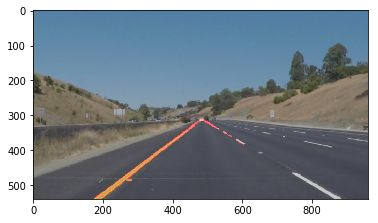

In [143]:

# Constants
kTestImagesRelativeInputPathDir = "test_images/"
kTestImagesRelativeOutputPathDir = "test_images_output/"
kTestVideosRelativeInputPathDir = "test_videos/"
kTestVideosRelativeOutputPathDir = "test_videos_output/"

# This boolean is used to determine if we need to produce intermediate image artifacts, after each processing operation like Gray Scaling etc.
generateIntermediateArtifacts = False

# Helper method(s)
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1, λ=0):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image):
    currentTime = datetime.datetime.now()
    currentTimeString = str(currentTime)
    # Important to not modify the original image, but instead work on it's copy
    original_image_copy = np.copy(image)
    greyscale_image = grayscale(original_image_copy)    
    gaussian_blurred_image = gaussian_blur(greyscale_image,5)
    canny_image = canny(gaussian_blurred_image,50,150)
    
    xsize = canny_image.shape[1]
    ysize = canny_image.shape[0]
    y_offset = 42
    left_bottom = [120, ysize]
    right_bottom = [850, ysize]
    left_top = [480, ysize/2 + y_offset]
    right_top = [490, ysize/2 + y_offset]
    region_of_interest_vertices = np.array([[left_top,right_top,right_bottom,left_bottom]], dtype=np.int32)
    region_of_interest_image = region_of_interest(canny_image,region_of_interest_vertices)
    hough_lines_image = hough_lines(region_of_interest_image, 2, np.pi/180, 15, 4, 10)
    original_image_overlaid_with_lanes = weighted_img(hough_lines_image,original_image_copy)
    
    if generateIntermediateArtifacts == True:
        original_image_copy_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_1_original_image_copy.jpg" 
        plt.imshow(original_image_copy,cmap='gray')
        plt.savefig(original_image_copy_filename)
        
        greyscale_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_2_grayscale_image.jpg" 
        plt.imshow(greyscale_image,cmap='gray')
        plt.savefig(greyscale_image_filename)
        
        gaussian_blurred_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_3_gaussian_blurred_image.jpg" 
        plt.imshow(gaussian_blurred_image,cmap='gray')
        plt.savefig(gaussian_blurred_image_filename)
        
        canny_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_4_canny_image.jpg" 
        plt.imshow(canny_image,cmap='gray')
        plt.savefig(canny_image_filename)
        
        region_of_interest_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_5_region_of_interest_image.jpg" 
        plt.imshow(region_of_interest_image,cmap='gray')
        plt.savefig(region_of_interest_image_filename)
        
        hough_lines_image_filename = kTestImagesRelativeOutputPathDir + currentTimeString + "_6_hough_lines_image.jpg" 
        plt.imshow(hough_lines_image,cmap='gray')
        plt.savefig(hough_lines_image_filename)       

    return original_image_overlaid_with_lanes

# # Using the Pipeline above to process image(s)
generateIntermediateArtifacts = True
testImagesInputDirectory = os.listdir(kTestImagesRelativeInputPathDir)
for imageFile in testImagesInputDirectory:
   input_file_relative_path = kTestImagesRelativeInputPathDir + imageFile
   output_file_relative_path = kTestImagesRelativeOutputPathDir + imageFile
   image_with_detected_lanes = process_image(mpimg.imread(input_file_relative_path))
   plt.imshow(image_with_detected_lanes)
   plt.savefig(output_file_relative_path)

# # Using the Pipeline above to process video(s)
generateIntermediateArtifacts = False
testVideosInputDirectory = os.listdir(kTestVideosRelativeInputPathDir)
for videoFile in testVideosInputDirectory:
   input_videofile_relative_path = kTestVideosRelativeInputPathDir + videoFile
   output_file_relative_path = kTestVideosRelativeOutputPathDir + videoFile
   input_clip = VideoFileClip(input_videofile_relative_path)
   output_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
   %time output_clip.write_videofile(output_file_relative_path, audio=False)

